In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Caractéristiques de la version 2

* Les solutions sont renormalisées pour globalement rentrer dans l'intervalle [0,1]. Renormalisation linéaire : y = x/(8*moyenne des x) + 3/8.

* Les seconds membres sont rescalés aussi avec StandardScaler()

* Le réseau auquel on aboutit après un peu d'optimisation est constitué de 3 couches : 50 Relu, 1000 Relu, 1 Sigmoïd

* Fonction loss : mean_squared_error

* Nombre d'entraînements : 10


Idées pour améliorer le réseau :

* L'entraîner avec plus de données

* L'entaîner sur les données reduced (gain de temps !)

* Pour l'optimisation sur le nombre de neurones par couche : procéder de façon plus méthodique en testant toutes les combinaisons simultanées (plutôt que faire varier une couche à la fois)

* Essayer de rescaler les solutions autrement (par exemple juste diviser par le max ?)

* Tester d'autres fonctions d'activation ?

# Configuration des données

In [2]:
#importation des données ICI
secondmembres = np.vstack(np.array(pd.DataFrame(pd.read_pickle("SecondMember_test.pickle"))[0]))
solutions = np.vstack(np.array(pd.DataFrame(pd.read_pickle("OurSolutions_test.pickle"))[0]))

5.9321668674061634e-05


{'whiskers': [<matplotlib.lines.Line2D at 0x1c980321c50>,
 'caps': [<matplotlib.lines.Line2D at 0x1c980330390>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c980321860>],
 'medians': [<matplotlib.lines.Line2D at 0x1c9803309b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c980330cf8>],
 'means': []}

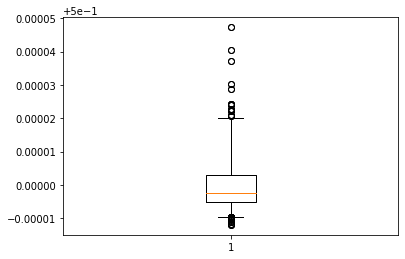

In [37]:
#Mise en forme des données
moyen_solutions = np.mean(solutions)
solutions = solutions/(8*moyen_solutions) + 3/8
moyen_solutions = np.mean(solutions)

#écart maximal entre les solutions 
val = (np.max(np.abs(solutions))-np.min(np.abs(solutions)))
print(val)

#Visualisation des solutions
plt.boxplot(solutions, whis = [2.5,97.5])

In [4]:
#Normalize
scaler = StandardScaler()
secondmembres = scaler.fit_transform(secondmembres)

pb_train, pb_test, sol_train, sol_test = train_test_split(secondmembres, solutions, test_size = 0.2, random_state = 1)

In [5]:
# pb_train = np.reshape(secondmembres,(832,1,118714))
# pb_test = np.reshape(secondmembres,(1040-832,1,118714))

# Création du modèle

In [6]:
model = tf.keras.models.Sequential()

########## Add the layers ##########
model.add(tf.keras.layers.Dense(150, activation = "relu"))
model.add(tf.keras.layers.Dense(100, activation = "relu"))
model.add(tf.keras.layers.Dense(1,activation = "sigmoid"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
########## Define the loss function ##########
model.compile(
        loss = "mean_squared_error",
        optimizer = "sgd",
        metrics = ["mean_squared_error"]
        )

# Entraînement du modèle

In [19]:
########### Train the model ##########
history = model.fit(pb_train, sol_train, epochs = 10, validation_split = 0.3)

Train on 582 samples, validate on 250 samples
Epoch 1/10
582/582 [==============================] - 28s 48ms/sample - loss: 1.5133e-07 - mean_squared_error: 1.5133e-07 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 2/10
582/582 [==============================] - 11s 18ms/sample - loss: 7.2454e-08 - mean_squared_error: 7.2454e-08 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/10
582/582 [==============================] - 11s 19ms/sample - loss: 4.0068e-08 - mean_squared_error: 4.0068e-08 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/10
582/582 [==============================] - 12s 21ms/sample - loss: 3.6508e-08 - mean_squared_error: 3.6508e-08 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/10
582/582 [==============================] - 12s 20ms/sample - loss: 2.7134e-08 - mean_squared_error: 2.7134e-08 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 6/10
582/582 [==============================] - 11s 18ms/sample - loss: 2.5396

In [22]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             multiple                  118715000 
_________________________________________________________________
dense_61 (Dense)             multiple                  100100    
_________________________________________________________________
dense_62 (Dense)             multiple                  101       
Total params: 118,815,201
Trainable params: 118,815,201
Non-trainable params: 0
_________________________________________________________________


# Visualisation des performances du modèle

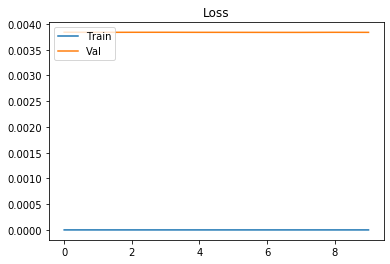

In [23]:
loss_curve = history.history["loss"]
loss_val_curve = history.history["val_loss"]

plt.plot(loss_curve, label = "Train")
plt.plot(loss_val_curve, label = "Val")
plt.legend(loc = 'upper left')
plt.title("Loss")
plt.show()

### Enorme overfitting !
Idées pour corriger :
* Modifier le nombres de neurones dans chaque couche : fait ci-dessous
* Modifier les fonctions d'activation
* Entraîner avec plus de données

# Évaluation du modèle

In [11]:
a = model.evaluate(pb_test, sol_test)

208/208 [==============================] - 1s 3ms/sample - loss: 0.0032 - mean_squared_error: 0.0032


# Sauvegarde du modèle

In [12]:
model.save("test1.h5")

# Recherche du meilleur modèle

In [13]:
# La 1 ère couche

loss = [];

for i in range(50,1001,50):
    
    model_temporaire = tf.keras.models.Sequential()
    model_temporaire.add(tf.keras.layers.Dense(i, activation = "relu"))
    model_temporaire.add(tf.keras.layers.Dense(100, activation = "relu"))
    model_temporaire.add(tf.keras.layers.Dense(1,activation = "sigmoid"))
    
    model_temporaire.compile(
        loss = "mean_squared_error",
        optimizer = "sgd",
        metrics = ["mean_squared_error"]
        )
    
    history_temporaire = model_temporaire.fit(pb_train, sol_train, epochs = 10, validation_split = 0.3)
    
    loss.append(model_temporaire.evaluate(pb_test, sol_test)[1])

Train on 582 samples, validate on 250 samples
Epoch 1/10
582/582 [==============================] - 3s 4ms/sample - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 2/10
582/582 [==============================] - 2s 4ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/10
582/582 [==============================] - 2s 4ms/sample - loss: 6.6423e-04 - mean_squared_error: 6.6423e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/10
582/582 [==============================] - 2s 3ms/sample - loss: 4.5163e-04 - mean_squared_error: 4.5163e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/10
582/582 [==============================] - 2s 3ms/sample - loss: 3.2441e-04 - mean_squared_error: 3.2441e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/10
582/582 [==============================] - 2s 3ms/sample - loss: 2.4199e-04 - mean_squared_error: 2

582/582 [==============================] - 7s 12ms/sample - loss: 4.8561e-06 - mean_squared_error: 4.8561e-06 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 10/10
208/208 [==============================] - 2s 12ms/sample - loss: 0.0019 - mean_squared_error: 0.0019
Train on 582 samples, validate on 250 samples
Epoch 1/10
582/582 [==============================] - 13s 22ms/sample - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 2/10
582/582 [==============================] - 7s 11ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/10
582/582 [==============================] - 7s 12ms/sample - loss: 3.4537e-04 - mean_squared_error: 3.4537e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 4/10
582/582 [==============================] - 6s 11ms/sample - loss: 1.2165e-04 - mean_squared_error: 1.2165e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
E

582/582 [==============================] - 11s 19ms/sample - loss: 1.0066e-05 - mean_squared_error: 1.0066e-05 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 7/10
582/582 [==============================] - 11s 18ms/sample - loss: 3.7744e-06 - mean_squared_error: 3.7744e-06 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 8/10
582/582 [==============================] - 12s 21ms/sample - loss: 1.5349e-06 - mean_squared_error: 1.5349e-06 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 9/10
582/582 [==============================] - 10s 18ms/sample - loss: 4.9438e-07 - mean_squared_error: 4.9438e-07 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 10/10
208/208 [==============================] - 9s 45ms/sample - loss: 0.0027 - mean_squared_error: 0.0027
Train on 582 samples, validate on 250 samples
Epoch 1/10
582/582 [==============================] - 52s 89ms/sample - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0039 - val_mean_squared_err

In [15]:
# L'index de l'érreur la plus petite
print(np.argmin(loss))

#L'érreur la plus petit
print(np.min(loss))

0
0.00095244165


### BILAN : Avec un nombre de neurones choisi un peu au hasard pour la deuxième couche, ce qui marche le mieux c'est 50 neurones pour la première couche

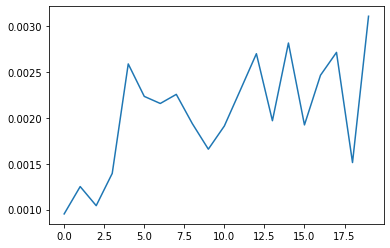

In [24]:
#Visualisation de résultat
plt.plot(loss)

In [27]:
# La 2 ème couche

loss = [];

for j in range(50,1001,50):
    
    model_temporaire = tf.keras.models.Sequential()
    model_temporaire.add(tf.keras.layers.Dense(50, activation = "relu"))
    model_temporaire.add(tf.keras.layers.Dense(j, activation = "relu"))
    model_temporaire.add(tf.keras.layers.Dense(1,activation = "sigmoid"))
    
    model_temporaire.compile(
        loss = "mean_squared_error",
        optimizer = "sgd",
        metrics = ["mean_squared_error"]
        )
    
    history_temporaire = model_temporaire.fit(pb_train, sol_train, epochs = 10, validation_split = 0.3)
    
    loss.append(model_temporaire.evaluate(pb_test, sol_test)[1])

Train on 582 samples, validate on 250 samples
Epoch 1/10
582/582 [==============================] - 7s 12ms/sample - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2/10
582/582 [==============================] - 2s 4ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 3/10
582/582 [==============================] - 2s 4ms/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/10
582/582 [==============================] - 3s 5ms/sample - loss: 5.4581e-04 - mean_squared_error: 5.4581e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 5/10
582/582 [==============================] - 2s 4ms/sample - loss: 3.2048e-04 - mean_squared_error: 3.2048e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 6/10
582/582 [==============================] - 2s 4ms/sample - loss: 1.9919e-04 - mean_squared_error: 1.9919e-

582/582 [==============================] - 2s 3ms/sample - loss: 3.1568e-04 - mean_squared_error: 3.1568e-04 - val_loss: 6.8055e-04 - val_mean_squared_error: 6.8055e-04
Epoch 8/10
582/582 [==============================] - 2s 4ms/sample - loss: 2.6453e-04 - mean_squared_error: 2.6453e-04 - val_loss: 6.4128e-04 - val_mean_squared_error: 6.4128e-04
Epoch 9/10
582/582 [==============================] - 2s 4ms/sample - loss: 2.2432e-04 - mean_squared_error: 2.2432e-04 - val_loss: 6.0724e-04 - val_mean_squared_error: 6.0724e-04
Epoch 10/10
208/208 [==============================] - 1s 3ms/sample - loss: 4.8111e-04 - mean_squared_error: 4.8111e-04
Train on 582 samples, validate on 250 samples
Epoch 1/10
582/582 [==============================] - 4s 6ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/10
582/582 [==============================] - 2s 4ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mea

Epoch 10/10
208/208 [==============================] - 1s 2ms/sample - loss: 5.2673e-04 - mean_squared_error: 5.2673e-04
Train on 582 samples, validate on 250 samples
Epoch 1/10
582/582 [==============================] - 4s 7ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/10
582/582 [==============================] - 3s 5ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/10
582/582 [==============================] - 3s 5ms/sample - loss: 8.8091e-04 - mean_squared_error: 8.8091e-04 - val_loss: 9.6115e-04 - val_mean_squared_error: 9.6115e-04
Epoch 4/10
582/582 [==============================] - 3s 5ms/sample - loss: 6.8156e-04 - mean_squared_error: 6.8156e-04 - val_loss: 8.3490e-04 - val_mean_squared_error: 8.3490e-04
Epoch 5/10
582/582 [==============================] - 3s 4ms/sample - loss: 5.4599e-04 - mean_squared_error: 5.4599e-04 - val_loss: 7.5178e-04 - 

Epoch 2/10
582/582 [==============================] - 2s 4ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/10
582/582 [==============================] - 2s 3ms/sample - loss: 8.1510e-04 - mean_squared_error: 8.1510e-04 - val_loss: 9.6180e-04 - val_mean_squared_error: 9.6180e-04
Epoch 4/10
582/582 [==============================] - 2s 3ms/sample - loss: 6.1342e-04 - mean_squared_error: 6.1342e-04 - val_loss: 8.3881e-04 - val_mean_squared_error: 8.3881e-04
Epoch 5/10
582/582 [==============================] - 2s 3ms/sample - loss: 4.9375e-04 - mean_squared_error: 4.9375e-04 - val_loss: 7.5224e-04 - val_mean_squared_error: 7.5224e-04
Epoch 6/10
582/582 [==============================] - 2s 3ms/sample - loss: 4.1436e-04 - mean_squared_error: 4.1436e-04 - val_loss: 6.9217e-04 - val_mean_squared_error: 6.9217e-04
Epoch 7/10
582/582 [==============================] - 2s 3ms/sample - loss: 3.6027e-04 - mean_squared_error: 3.6027e

### BILAN : Avec 50 neurones pour la première couche, ce qui marche le mieux c'est 1000 neurones pour la deuxième couche

19
0.00040331253


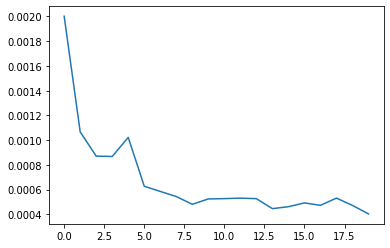

In [28]:
# L'index de l'érreur la plus petite
print(np.argmin(loss))

#L'érreur la plus petit
print(np.min(loss))

#Visualisation de résultat
plt.plot(loss)

# Création du meilleur modèle

Train on 582 samples, validate on 250 samples
Epoch 1/10
582/582 [==============================] - 4s 6ms/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/10
582/582 [==============================] - 3s 4ms/sample - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/10
582/582 [==============================] - 2s 4ms/sample - loss: 9.7217e-04 - mean_squared_error: 9.7217e-04 - val_loss: 8.3485e-04 - val_mean_squared_error: 8.3485e-04
Epoch 4/10
582/582 [==============================] - 2s 4ms/sample - loss: 7.0551e-04 - mean_squared_error: 7.0551e-04 - val_loss: 6.9334e-04 - val_mean_squared_error: 6.9334e-04
Epoch 5/10
582/582 [==============================] - 2s 4ms/sample - loss: 5.4374e-04 - mean_squared_error: 5.4374e-04 - val_loss: 6.0351e-04 - val_mean_squared_error: 6.0351e-04
Epoch 6/10
582/582 [==============================] - 2s 4ms/sample - loss: 4.3803e-04

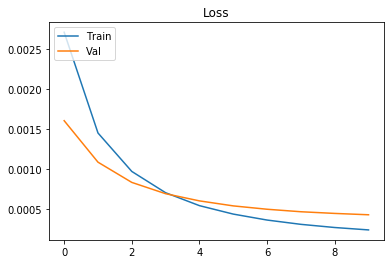

208/208 [==============================] - 1s 3ms/sample - loss: 5.3596e-04 - mean_squared_error: 5.3596e-04


In [30]:
model_optimise = tf.keras.models.Sequential()

########## Add the layers ##########
model_optimise.add(tf.keras.layers.Dense(50, activation = "relu"))
model_optimise.add(tf.keras.layers.Dense(1000, activation = "relu"))
model_optimise.add(tf.keras.layers.Dense(1,activation = "sigmoid"))

########## Define the loss function ##########
model_optimise.compile(
        loss = "mean_squared_error",
        optimizer = "sgd",
        metrics = ["mean_squared_error"]
        )

########### Train the model ##########
history_optimise = model_optimise.fit(pb_train, sol_train, epochs = 10, validation_split = 0.3)


########### Overfitting ? ###########
loss_curve = history_optimise.history["loss"]
loss_val_curve = history_optimise.history["val_loss"]

plt.plot(loss_curve, label = "Train")
plt.plot(loss_val_curve, label = "Val")
plt.legend(loc = 'upper left')
plt.title("Loss")
plt.show()


a = model_optimise.evaluate(pb_test, sol_test)
model_optimise.save("test_optimise.h5")